# Depfake Detection Training

In [ ]:
!pip install keras-tuner
!pip install ultralytics

In [ ]:
from google.colab import drive
import os
import numpy as np
import logging
import matplotlib.pyplot as plt
import cv2
import math
import tensorflow as tf
from tensorflow.keras.layers import Resizing, Rescaling, Conv2D, BatchNormalization, MaxPool2D, SeparableConv2D, ReLU, Add, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import Layer
from tensorflow.keras import Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Recall, AUC
from tensorflow.keras.callbacks import  EarlyStopping
from tensorflow.keras.models import load_model
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import keras_tuner as kt
from ultralytics import YOLO

logging.getLogger('ultralytics').setLevel(logging.ERROR)


In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
CONFIGURATION = {
    "TRAIN_RATIO" : 0.8,
    "VALIDATION_RATIO" : 0.1,
    "TEST_RATIO" : 0.1,
    "BATCH_SIZE" : 32,
    "IMAGE_SIZE" : 299,
    "BETA_1": 0.9,
    "BETA_2": 0.999,
    "EPSILON": 1e-08,
    "LEARNING_RATE": 0.0002,
    "EPOCHS": 10,
    "SEED": 42,
    "CLASS_NAMES": ["original", "manipulated"],
    "STEPS_PER_EPOCH": 29197,
    "VALIDATION_STEPS": 3649
}

## Reconstruct Database

In [ ]:
train_dataset_path = os.path.join(os.getcwd(), "drive/MyDrive/DeepFake Detection/tfrecords", 'train_dataset', 'shard_{:01d}.tfrecord')
validation_dataset_path = os.path.join(os.getcwd(), "drive/MyDrive/DeepFake Detection/tfrecords", 'validation_dataset', 'shard_{:01d}.tfrecord')
test_dataset_path = os.path.join(os.getcwd(), "drive/MyDrive/DeepFake Detection/tfrecords", 'test_dataset', 'shard_{:01d}.tfrecord')
NUM_TRAIN_SHARDS = 60
NUM_VALIDATION_SHARDS = 15
NUM_TEST_SHARDS = 15

In [ ]:
reconstructed_train_dataset = tf.data.TFRecordDataset(
    filenames =[train_dataset_path.format(p) for p in range(NUM_TRAIN_SHARDS)] )

In [ ]:
reconstructed_validation_dataset = tf.data.TFRecordDataset(
    filenames =[validation_dataset_path.format(p) for p in range(NUM_VALIDATION_SHARDS)])

In [ ]:
reconstructed_test_dataset = tf.data.TFRecordDataset(
    filenames =[test_dataset_path.format(p) for p in range(NUM_TEST_SHARDS)])

In [ ]:
def parse_tfrecords(example):

    feature_description = {
          "images": tf.io.FixedLenFeature([], tf.string),
          "labels": tf.io.FixedLenFeature([], tf.int64),
      }

    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(
        example["images"], channels = 3), dtype = tf.float32)

    return example["images"], example["labels"]


In [ ]:
training_dataset = (
    reconstructed_train_dataset
    .map(parse_tfrecords)
    .shuffle(buffer_size = 1000)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .repeat()
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
validation_dataset = (
    reconstructed_validation_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .repeat()
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
test_dataset = (
    reconstructed_test_dataset
    .map(parse_tfrecords)
    .shuffle(buffer_size = 1000)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
validation_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Visualization of the Database

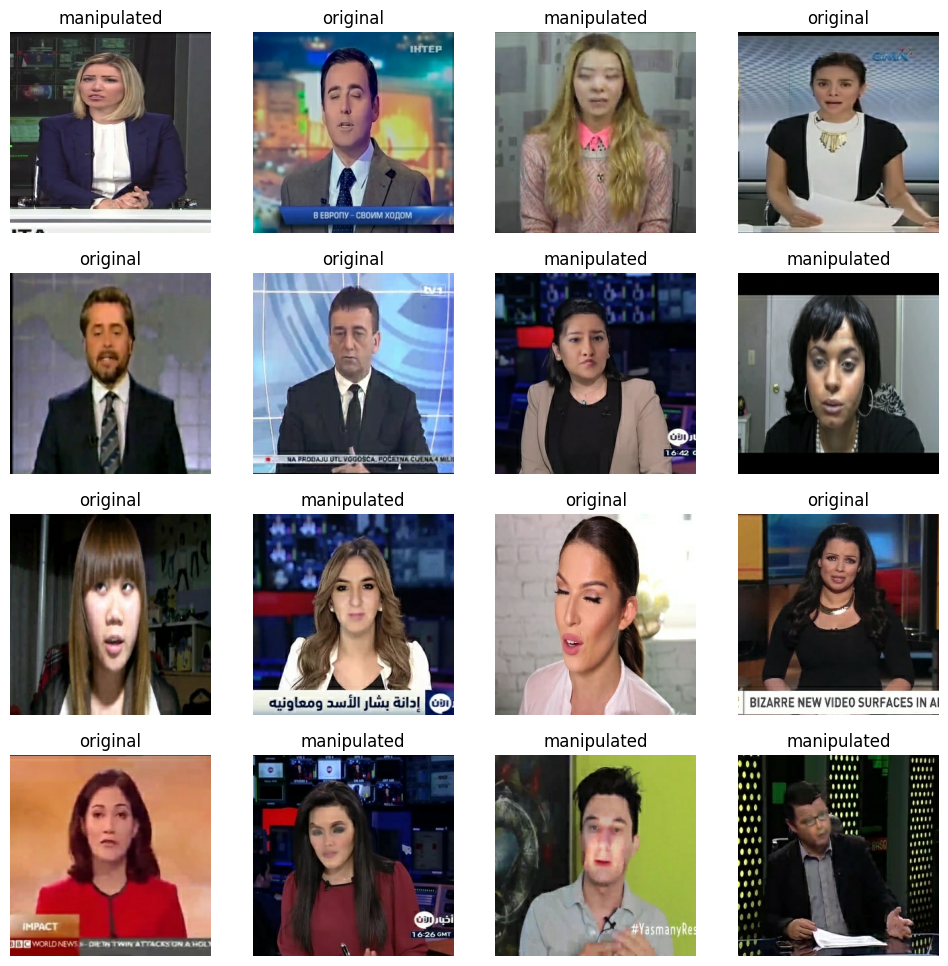

In [ ]:
plt.figure(figsize = (12,12))

for images, labels in test_dataset.take(1):
  for i in range(16):
    tensor = labels[i].numpy()
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i])
    plt.title(CONFIGURATION["CLASS_NAMES"][int(tensor.item())])
    plt.axis("off")

## Xception

In [ ]:
class Convolution(Layer):
  def __init__(self, n_filters, kernel_size, n_strides=1):
    super(Convolution, self).__init__(name = "convolution")
    self.convolution = Conv2D(filters = n_filters, kernel_size = kernel_size, strides = n_strides, padding = "same",  activation = "relu")
    self.batch_normalization = BatchNormalization()

  def call(self, x, training = True):
    x = self.convolution(x)
    x = self.batch_normalization(x, training = training)
    return x


In [ ]:
class SeparableConvolution(Layer):
  def __init__(self, n_filters, kernel_size, n_strides=1):
    super(SeparableConvolution, self).__init__(name="separable_convolution")
    self.separable_convolution = SeparableConv2D(filters=n_filters, kernel_size=kernel_size, strides=n_strides, padding="same", activation=None)
    self.batch_normalization = BatchNormalization()
    self.dropout = Dropout(0.2)

  def call(self, x, training=True):
    x = self.separable_convolution(x)
    x = self.batch_normalization(x, training=training)
    if training:
      x = self.dropout(x, training=training)
    return x

In [ ]:
class SumConvolution(Layer):
  def __init__(self, n_filters, kernel_size, n_strides=1):
    super(SumConvolution, self).__init__(name = "sum_convolution")
    self.sum_convolution = Conv2D(filters = n_filters, kernel_size = kernel_size, strides = n_strides, padding = "same",  activation = None)
    self.batch_normalization = BatchNormalization()

  def call(self, x, training = True):
    x = self.sum_convolution(x)
    x = self.batch_normalization(x, training = training)
    return x

In [ ]:
class EntryFlow(Layer):
    def __init__(self, filters):
        super(EntryFlow, self).__init__(name="entry_flow")
        self.convolution1 = Convolution(filters[0], 3, 2)
        self.convolution2 = Convolution(filters[1], 3)

        self.sum_convolution1 = Convolution(filters[2], 1, 2)

        self.separable_convolution1 = SeparableConvolution(filters[2], 3)
        self.activation = ReLU()
        self.separable_convolution2 = SeparableConvolution(filters[2], 3)
        self.max_pooling = MaxPool2D(pool_size=(3, 3), strides=2, padding="same")

        self.sum_convolution2 = Convolution(filters[3], 1, 2)

        self.separable_convolution3 = SeparableConvolution(filters[3], 3)
        self.separable_convolution4 = SeparableConvolution(filters[3], 3)

        self.sum_convolution3 = Convolution(filters[4], 1, 2)

        self.separable_convolution5 = SeparableConvolution(filters[4], 3)
        self.separable_convolution6 = SeparableConvolution(filters[4], 3)

    def call(self, x, training=True):
        x = self.convolution1(x, training = training)
        x = self.convolution2(x, training = training)
        tensor = self.sum_convolution1(x, training = training)

        x = self.separable_convolution1(x, training = training)
        x = self.activation(x)
        x = self.separable_convolution2(x, training = training)
        x = self.max_pooling(x)

        x = Add()([tensor, x])
        tensor = self.sum_convolution2(x, training = training)

        x = self.activation(x)
        x = self.separable_convolution3(x, training = training)
        x = self.activation(x)
        x = self.separable_convolution4(x, training = training)
        x = self.max_pooling(x)

        x = Add()([tensor, x])
        tensor = self.sum_convolution3(x, training = training)

        x = self.activation(x)
        x = self.separable_convolution5(x, training = training)
        x = self.activation(x)
        x = self.separable_convolution6(x, training = training)
        x = self.max_pooling(x)

        x = Add()([tensor, x])

        return x

In [ ]:
class MiddleFlow(Layer):
    def __init__(self, filters):
        super(MiddleFlow, self).__init__(name="middle_flow")
        self.activation = ReLU()
        self.separable_convolution1 = SeparableConvolution(filters[4], 3)
        self.separable_convolution2 = SeparableConvolution(filters[4], 3)
        self.separable_convolution3 = SeparableConvolution(filters[4], 3)

    def call(self, x, tensor, training=True):
        for i in range(8):
            x = self.activation(x)
            x = self.separable_convolution1(x, training = training)
            x = self.activation(x)
            x = self.separable_convolution2(x, training = training)
            x = self.activation(x)
            x = self.separable_convolution3(x, training = training)
            x = Add()([tensor, x])
        return x

In [ ]:
class ExitFlow(Layer):
  def __init__(self, filters):
    super(ExitFlow, self).__init__(name = "exit_flow")
    self.sum_convolution = SumConvolution(filters[5], 1, 2)

    self.activation = ReLU()
    self.separable_convolution1 = SeparableConvolution(filters[4], 3)
    self.separable_convolution2 = SeparableConvolution(filters[5], 3)
    self.max_pooling = MaxPool2D(pool_size = (3,3), strides = 2, padding = "same")

    self.separable_convolution3 = SeparableConvolution(filters[6], 3)
    self.separable_convolution4 = SeparableConvolution(filters[7], 3)
    self.global_average_pooling = GlobalAveragePooling2D()

    #Optionally one may insert fully-connected layers beffore the logistic regression layer, which is explored in the experimental evaluation section (in particular, see figures 7 and 8)

  def call(self, x, tensor, training = True):
    tensor = self.sum_convolution(tensor, training = training)

    x = self.activation(x)
    x = self.separable_convolution1(x, training = training)
    x = self.activation(x)
    x = self.separable_convolution2(x, training = training)
    x = self.max_pooling(x)

    x = Add()([tensor, x])

    x = self.separable_convolution3(x, training = training)
    x = self.activation(x)
    x = self.separable_convolution4(x, training = training)
    x = self.activation(x)
    x = self.global_average_pooling(x)

    return x



In [ ]:
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
class XceptionNet(Model):
    def __init__(self, filters, trainable=True, name="xception_net", **kwargs):
        super(XceptionNet, self).__init__(name=name, **kwargs)
        self.entry_flow = EntryFlow(filters)
        self.middle_flow = MiddleFlow(filters)
        self.exit_flow = ExitFlow(filters)
        self.dense = Dense(1, activation="sigmoid")
        self.trainable = trainable
        self.filters = filters

    def call(self, x, training=True):
        x = self.entry_flow(x, training=training)
        tensor = x
        x = self.middle_flow(x, tensor, training=training)
        tensor = x
        x = self.exit_flow(x, tensor, training=training)
        x = self.dense(x)
        return x

    def summary(self):
        x = Input(shape=(299, 299, 3))
        model = Model(inputs=[x], outputs=self.call(x))
        return model.summary()

    def get_config(self):
        config = super(XceptionNet, self).get_config()
        config.update({
            "filters": self.filters,
            "trainable": self.trainable
        })
        return config

    @classmethod
    def from_config(cls, config):
        filters = config.pop('filters')
        return cls(filters=filters, **config)



## Training

In [ ]:
train_1 = [16,32,64,128,364,512,768,1024]
train_2 = [16,32,64,128,364,512,768,1024]
train_3 = [8,16,32,64,182,256,384,512]

In [ ]:
adam_optimizer = Adam(
    learning_rate = CONFIGURATION["LEARNING_RATE"]
    )

In [ ]:
es_callback = EarlyStopping(
    monitor = "val_loss",
    mode = "auto",
    patience = 3,
    restore_best_weights = True,
    baseline = None
)

In [ ]:
total_examples = 1167889
manipulated_examples = 913077
original_examples = 254812
manipulated_weight = total_examples/manipulated_examples
original_weight = total_examples/original_examples
class_weights = {0: original_weight, 1: manipulated_weight}
class_weights

{0: 4.583335949641304, 1: 1.2790695636841143}

In [ ]:
loss_fn = BinaryCrossentropy()

In [ ]:
metrics = [BinaryAccuracy(name = "accuracy"),
           Recall(name = "recall"),
           AUC(name = "auc")
           ]

## Train 1

In [ ]:
model = XceptionNet(train_1)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ entry_flow (EntryFlow)    │ (None, 19, 19, 364)    │        287,280 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ middle_flow (MiddleFlow)  │ (None, 19, 19, 364)    │        412,776 │ entry_flow[0][0],      │
│                           │                        │                │ entry_flow[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ exit_flow (ExitFlow)      │ (None, 1024)           │      1,718,852 │ middle_flow[0][0],     │
│                           │                        │                │ middle_flow[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │          1,025 │ exit_flow[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,419,933 (9.23 MB)

 Trainable params: 2,407,957 (9.19 MB)

 Non-trainable params: 11,976 (46.78 KB)

In [ ]:
log_dir = "drive/MyDrive/DeepFake Detection/logs/train_1"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

In [ ]:
model.compile(loss = loss_fn, optimizer = adam_optimizer, metrics = metrics)

In [ ]:
history = model.fit (
training_dataset, validation_data = validation_dataset, epochs = 10, steps_per_epoch = 29190, validation_steps = 3640, callbacks = [es_callback, tensorboard_callback], class_weight = class_weights
)


Epoch 1/10
29190/29190 ━━━━━━━━━━━━━━━━━━━━ 1975s 66ms/step - accuracy: 0.5995 - auc: 0.6593 - loss: 1.2735 - recall: 0.5938 - val_accuracy: 0.5897 - val_auc: 0.8574 - val_loss: 0.7686 - val_recall: 0.4883
Epoch 2/10
29190/29190 ━━━━━━━━━━━━━━━━━━━━ 1894s 65ms/step - accuracy: 0.7782 - auc: 0.8806 - loss: 0.8550 - recall: 0.7640 - val_accuracy: 0.7797 - val_auc: 0.9265 - val_loss: 0.4443 - val_recall: 0.7359
Epoch 3/10
29190/29190 ━━━━━━━━━━━━━━━━━━━━ 1885s 65ms/step - accuracy: 0.8310 - auc: 0.9273 - loss: 0.6738 - recall: 0.8171 - val_accuracy: 0.8034 - val_auc: 0.9411 - val_loss: 0.4249 - val_recall: 0.7634
Epoch 4/10
29190/29190 ━━━━━━━━━━━━━━━━━━━━ 1858s 64ms/step - accuracy: 0.8617 - auc: 0.9494 - loss: 0.5618 - recall: 0.8489 - val_accuracy: 0.7507 - val_auc: 0.9425 - val_loss: 0.5504 - val_recall: 0.6887
Epoch 5/10
29190/29190 ━━━━━━━━━━━━━━━━━━━━ 1852s 63ms/step - accuracy: 0.8842 - auc: 0.9628 - loss: 0.4813 - recall: 0.8734 - val_accuracy: 0.8108 - val_auc: 0.9467 - val_loss

In [ ]:
model.save("drive/MyDrive/DeepFake Detection/xception_net_train_1.keras")

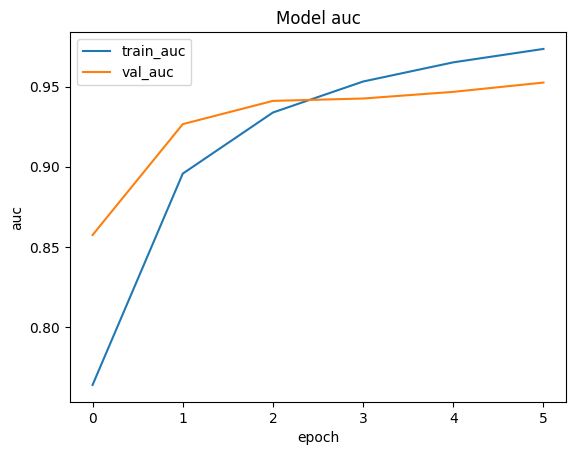

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train_auc', 'val_auc'])
plt.show()

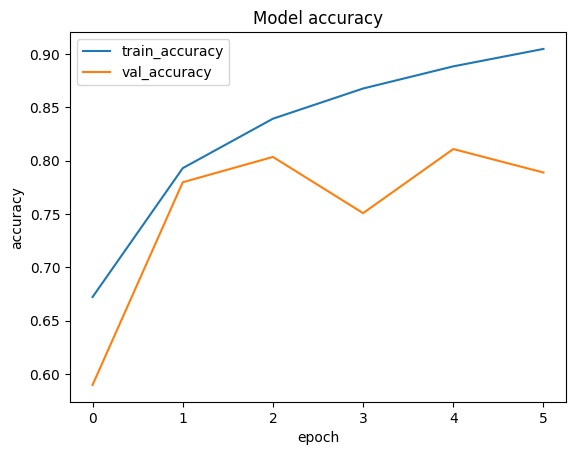

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

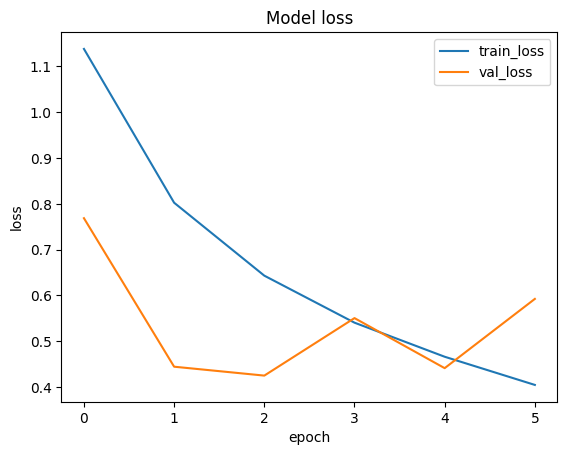

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

## Train 2

In [ ]:
model = XceptionNet(train_2)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ entry_flow (EntryFlow)    │ (None, 19, 19, 364)    │        287,280 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ middle_flow (MiddleFlow)  │ (None, 19, 19, 364)    │        412,776 │ entry_flow[0][0],      │
│                           │                        │                │ entry_flow[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ exit_flow (ExitFlow)      │ (None, 1024)           │      1,718,852 │ middle_flow[0][0],     │
│                           │                        │                │ middle_flow[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │          1,025 │ exit_flow[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,419,933 (9.23 MB)

 Trainable params: 2,407,957 (9.19 MB)

 Non-trainable params: 11,976 (46.78 KB)

In [ ]:
log_dir = "drive/MyDrive/DeepFake Detection/logs/train_2"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

In [ ]:
model.compile(loss = loss_fn, optimizer = adam_optimizer, metrics = metrics)


In [ ]:
history = model.fit (
training_dataset, validation_data = validation_dataset, epochs = 10, steps_per_epoch = 29190, validation_steps = 3640, callbacks = [es_callback, tensorboard_callback], class_weight = class_weights
)


Epoch 1/10
29190/29190 ━━━━━━━━━━━━━━━━━━━━ 2134s 71ms/step - accuracy: 0.5491 - auc: 0.5801 - loss: 1.3541 - recall: 0.5468 - val_accuracy: 0.6945 - val_auc: 0.8032 - val_loss: 0.5630 - val_recall: 0.6694
Epoch 2/10
29190/29190 ━━━━━━━━━━━━━━━━━━━━ 2048s 70ms/step - accuracy: 0.7113 - auc: 0.8068 - loss: 1.0582 - recall: 0.6983 - val_accuracy: 0.7845 - val_auc: 0.8636 - val_loss: 0.4467 - val_recall: 0.7909
Epoch 3/10
29190/29190 ━━━━━━━━━━━━━━━━━━━━ 2042s 70ms/step - accuracy: 0.7723 - auc: 0.8778 - loss: 0.8618 - recall: 0.7549 - val_accuracy: 0.8263 - val_auc: 0.8889 - val_loss: 0.3671 - val_recall: 0.8501
Epoch 4/10
29190/29190 ━━━━━━━━━━━━━━━━━━━━ 2034s 70ms/step - accuracy: 0.8082 - auc: 0.9102 - loss: 0.7442 - recall: 0.7922 - val_accuracy: 0.8139 - val_auc: 0.9121 - val_loss: 0.3703 - val_recall: 0.8016
Epoch 5/10
29190/29190 ━━━━━━━━━━━━━━━━━━━━ 2034s 70ms/step - accuracy: 0.8326 - auc: 0.9294 - loss: 0.6615 - recall: 0.8176 - val_accuracy: 0.8129 - val_auc: 0.9259 - val_loss

In [ ]:
model.save("drive/MyDrive/DeepFake Detection/xception_net_train_2.keras")

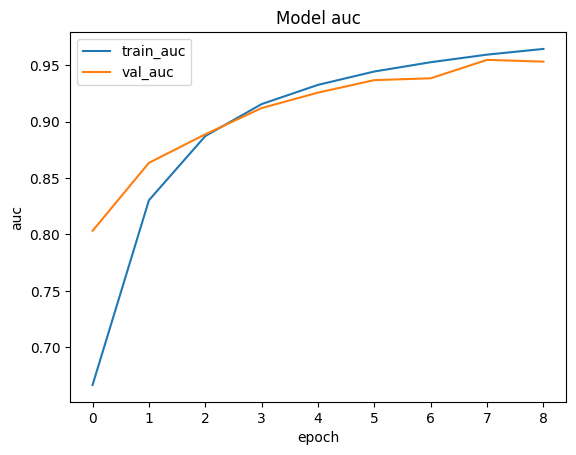

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train_auc', 'val_auc'])
plt.show()

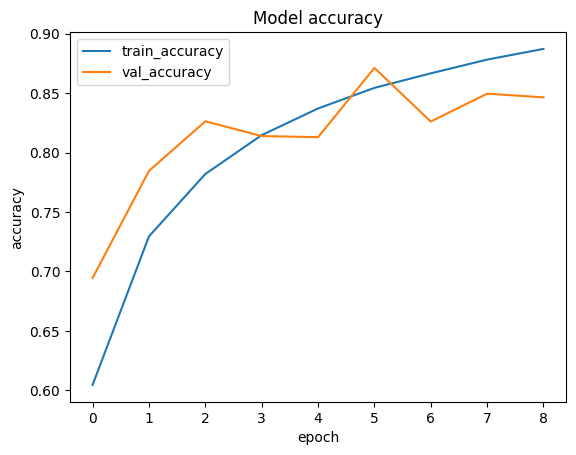

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

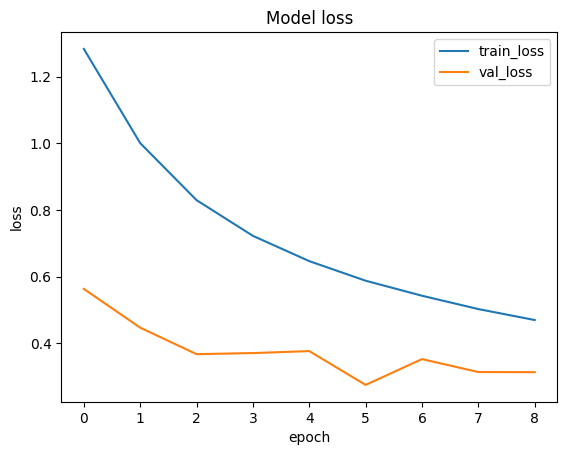

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

## Train 3

In [ ]:
model = XceptionNet(train_3)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ entry_flow (EntryFlow)    │ (None, 19, 19, 182)    │         75,828 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ middle_flow (MiddleFlow)  │ (None, 19, 19, 182)    │        107,016 │ entry_flow[0][0],      │
│                           │                        │                │ entry_flow[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ exit_flow (ExitFlow)      │ (None, 512)            │        438,206 │ middle_flow[0][0],     │
│                           │                        │                │ middle_flow[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │            513 │ exit_flow[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 621,563 (2.37 MB)

 Trainable params: 615,575 (2.35 MB)

 Non-trainable params: 5,988 (23.39 KB)

In [ ]:
log_dir = "drive/MyDrive/DeepFake Detection/logs/train_3"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

In [ ]:
model.compile(loss = loss_fn, optimizer = adam_optimizer, metrics = metrics)


In [ ]:
history = model.fit (
training_dataset, validation_data = validation_dataset, epochs = 5, steps_per_epoch = 29190, validation_steps = 3640, callbacks = [es_callback, tensorboard_callback], class_weight = class_weights
)


Epoch 1/5
29190/29190 ━━━━━━━━━━━━━━━━━━━━ 1331s 46ms/step - accuracy: 0.6094 - auc: 0.6610 - loss: 1.2866 - recall: 0.6085 - val_accuracy: 0.7065 - val_auc: 0.8264 - val_loss: 0.5534 - val_recall: 0.6763
Epoch 2/5
29190/29190 ━━━━━━━━━━━━━━━━━━━━ 1297s 44ms/step - accuracy: 0.7331 - auc: 0.8314 - loss: 0.9992 - recall: 0.7205 - val_accuracy: 0.7597 - val_auc: 0.8821 - val_loss: 0.4712 - val_recall: 0.7310
Epoch 3/5
29190/29190 ━━━━━━━━━━━━━━━━━━━━ 1286s 44ms/step - accuracy: 0.7803 - auc: 0.8835 - loss: 0.8446 - recall: 0.7653 - val_accuracy: 0.7151 - val_auc: 0.9001 - val_loss: 0.5749 - val_recall: 0.6523
Epoch 4/5
29190/29190 ━━━━━━━━━━━━━━━━━━━━ 1296s 44ms/step - accuracy: 0.8087 - auc: 0.9100 - loss: 0.7471 - recall: 0.7937 - val_accuracy: 0.7829 - val_auc: 0.9176 - val_loss: 0.4420 - val_recall: 0.7462
Epoch 5/5
29190/29190 ━━━━━━━━━━━━━━━━━━━━ 1271s 44ms/step - accuracy: 0.8308 - auc: 0.9275 - loss: 0.6726 - recall: 0.8169 - val_accuracy: 0.6960 - val_auc: 0.9229 - val_loss: 0.7

In [ ]:
model.save("drive/MyDrive/DeepFake Detection/xception_net_train_3.keras")

## Test

In [ ]:
class TrackFace():
  def __init__(self):
    self.model = YOLO('yolov8n.pt', verbose=False)
    self.total_frames_extracted = 0

  def track(self, frame):
    self.img_height, self.img_width, _ = frame.shape
    results = self.model(frame)
    face_box = self._get_face(results)
    cropped_frame = self._crop_face(frame, face_box)
    return cropped_frame

  def _get_face(self, results):
    main_face = None
    for res in results[0].boxes:
      if res.cls == 0:
        face_box = res.xyxy[0].cpu().numpy()
        main_face = self._get_main_face(main_face, face_box)
    if main_face is None:
      return [0, 0, self.img_width, self.img_height]
    return main_face

  def _get_main_face(self, main_face, face_box):
    if main_face is None:
      return face_box
    if self._get_area(face_box) > self._get_area(main_face):
      return face_box
    return main_face

  def _get_area(self, box):
    x1, y1, x2, y2 = box
    area = (x2 - x1) * (y2 - y1)
    return area

  def _crop_face(self, frame, face_box):
    extended_box = self._extend_box(face_box)
    x1, y1, x2, y2 = extended_box
    cropped_face = frame[y1:y2, x1:x2]
    return cropped_face

  def _extend_box(self, box, factor=1.3):
    x1, y1, x2, y2 = box
    box_width, box_height = x2 - x1, y2 - y1
    center_x, center_y = self._calculate_center(box)
    extended_box_width, extended_box_height = self._calculate_new_dimensions(box_width, box_height, factor)
    return self._calculate_new_coordinates(center_x, center_y, extended_box_width, extended_box_height )

  def _calculate_center(self, box):
    x1, y1, x2, y2 = box
    center_x = x1 + (x2 - x1) / 2
    center_y = y1 + (y2 - y1) / 2
    return center_x, center_y

  def _calculate_new_dimensions(self, width, height, factor):
    extended_box_width = width * factor
    extended_box_height = height * factor
    return extended_box_width, extended_box_height

  def _calculate_new_coordinates(self, center_x, center_y, extended_box_width, extended_box_height):
    extended_x1 = max(0, int(center_x - extended_box_width / 2))
    extended_y1 = max(0, int(center_y - extended_box_height / 2))
    extended_x2 = min(self.img_width, int(center_x + extended_box_width / 2))
    extended_y2 = min(self.img_height, int(center_y + extended_box_height / 2))
    return extended_x1, extended_y1, extended_x2, extended_y2

In [ ]:
def predict(video_url):
  count_original = 0
  count_manipulated = 0
  capture = cv2.VideoCapture(video_url)
  if not capture.isOpened():
    print("Errore: impossibile aprire il file video")
    return
  tensors = create_frame_tensor(capture)
  capture.release()
  predictions = []
  for tensor in tensors:
    frame_prediction = model.predict(tensor)
    print(frame_prediction)
    if frame_prediction < 0.56:
      frame_prediction = "original"
      count_original += 1
    else:
      frame_prediction = "manipulated"
      count_manipulated += 1
    predictions.append(frame_prediction)
  result = max(set(predictions), key=predictions.count)
  return result, count_original, count_manipulated

def create_frame_tensor(capture):
  track_face = TrackFace()
  frame_count = 0
  frame_tensors = []
  while True:
    is_a_frame, frame = capture.read()
    if not is_a_frame:
      break
    cropped_frame = track_face.track(frame)
    tensor = tf.convert_to_tensor(cropped_frame, dtype=tf.float32)
    resize_tensor = tf.keras.Sequential([
       Resizing(CONFIGURATION["IMAGE_SIZE"], CONFIGURATION["IMAGE_SIZE"]),
       Rescaling(1./255),
    ])
    tensor = tf.convert_to_tensor(cropped_frame, dtype=tf.float32)
    tensor = tf.expand_dims(tensor, axis=0)

    frame_tensors.append(resize_tensor(tensor))
  return frame_tensors


In [ ]:
model = load_model("drive/MyDrive/DeepFake Detection/models/xception_net_train_2.keras")

In [ ]:
results = model.evaluate(test_dataset, steps = 3640)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

3640/3640 ━━━━━━━━━━━━━━━━━━━━ 420s 112ms/step - accuracy: 0.8711 - auc: 0.9342 - loss: 0.2804 - recall: 0.8865
Test Loss: 0.278164803981781
Test Accuracy: 0.8715230226516724


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
0.999827
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
0.9491455
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
0.17625304
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
0.617953
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0.73975617
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
0.1664144
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
0.49103856
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
0.86685985
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0.93528366
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0.9840813
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
0.99858165
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
0.8225317
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
0.99923396
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
0.99964416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
0.9999455
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
0.8676001


<Figure size 1200x1200 with 0 Axes>

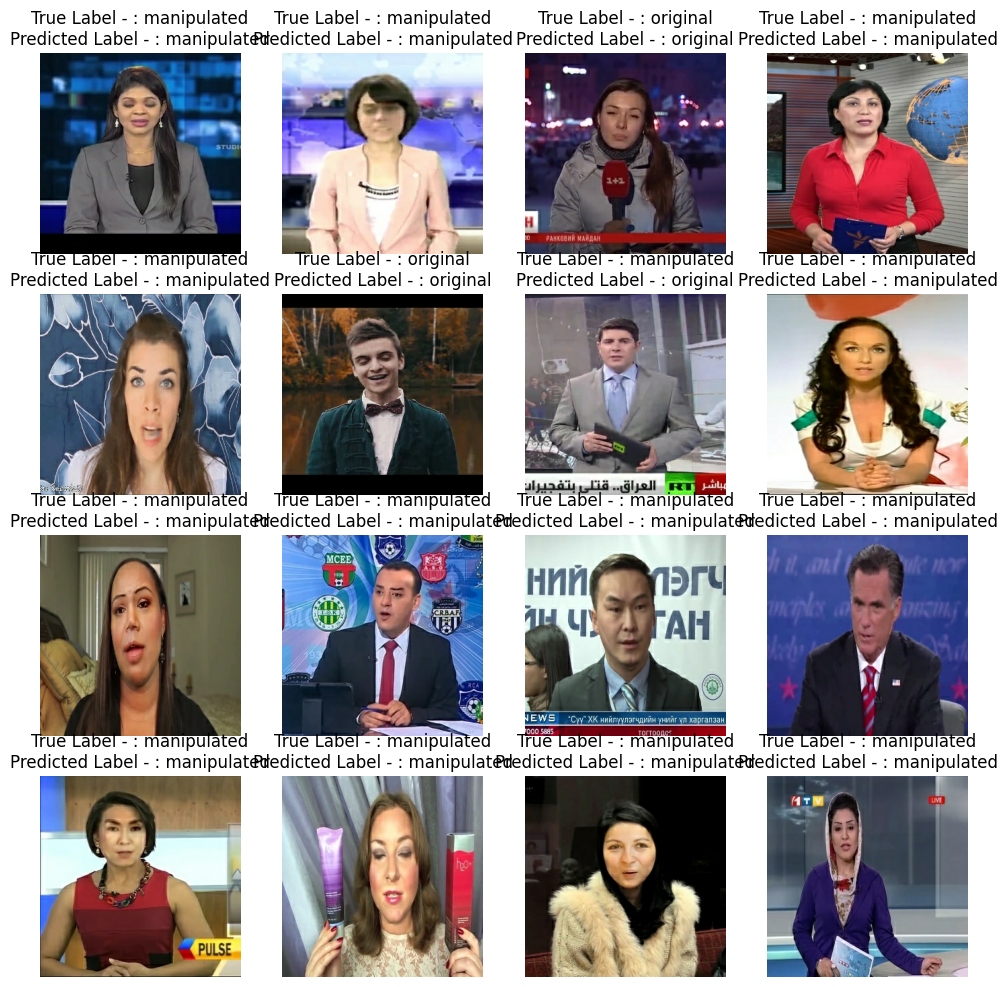

In [ ]:
plt.figure(figsize = (12,12))

plt.figure(figsize=(12, 12))

for images, labels in test_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        true_label = int(labels[i].numpy())
        predicted_prob = model.predict(tf.expand_dims(images[i], axis=0))[0][0]
        predicted_label = int(predicted_prob >= 0.56)
        print(predicted_prob)
        plt.title("True Label - : " + CONFIGURATION["CLASS_NAMES"][true_label]
                  + "\n" + "Predicted Label - : "
                  + CONFIGURATION["CLASS_NAMES"][predicted_label])
        plt.axis("off")

plt.show()


In [ ]:
predicted = []
labels = []

for im, label in test_dataset:
    predictions = model(im)
    truncated_predictions = np.trunc(predictions.numpy() * 100) / 100
    predicted.append(truncated_predictions)
    labels.append(label.numpy())

predicted = np.concatenate(predicted).flatten()
labels = np.concatenate(labels).flatten()


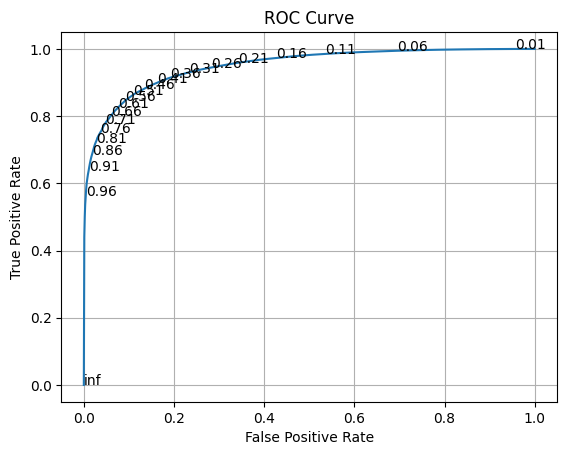

In [ ]:
fp, tp, thresholds = roc_curve(labels, predicted)
plt.plot(fp, tp)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()

skip = 5
for i in range(0, len(thresholds), skip):
  plt.text(fp[i], tp[i], thresholds[i])
plt.show()

[1 1 1 ... 1 1 1]
[0 1 1 ... 1 0 1]
[[23361  2344]
 [14082 77030]]


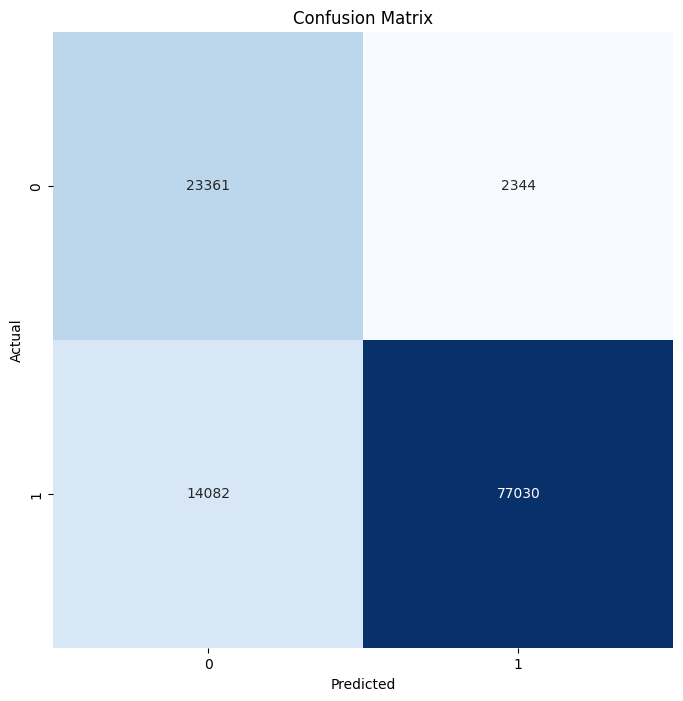

In [ ]:
print(labels)

pred = (predicted >= 0.56).astype(int)
print(pred)
lab = labels

cm = confusion_matrix(lab, pred)
print(cm)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
deepfake_test = "drive/MyDrive/DeepFake Detection/test/test_deepfake.mp4"
face2face_test = "drive/MyDrive/DeepFake Detection/test/test_face2face.mp4"
faceswap_test = "drive/MyDrive/DeepFake Detection/test/test_faceswap.mp4"
neuraltexture_test = "drive/MyDrive/DeepFake Detection/test/test_neuraltexture.mp4"
original_test = "drive/MyDrive/DeepFake Detection/test/test_original.mp4"


In [ ]:
prediction, count_original, count_manipulated = predict(deepfake_test)
total = count_original + count_manipulated
print(f"Risultato finale: {prediction}")
print(f"probabilità che sia originale: {(count_original/total*100):2f}%")
print(f"probabilità che sia manipolato: {(count_manipulated/total*100):.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[     0.8856]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[    0.87544]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[    0.87874]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[    0.91294]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[    0.91293]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[    0.93584]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[    0.90841]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[    0.89226]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[    0.89478]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[     0.9054]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[    0.85134]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[    0.87725]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[    0.88035]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[    0.88695]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[    0.86426]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[    0.88278]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[    0.89736]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[    0.91642]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
prediction, count_original, count_manipulated = predict(face2face_test)
total = count_original + count_manipulated
print(f"Risultato finale: {prediction}")
print(f"probabilità che sia originale: {(count_original/total*100):2f}%")
print(f"probabilità che sia manipolato: {(count_manipulated/total*100):.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[     0.5077]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[    0.60612]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[    0.65725]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[    0.68502]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[    0.75104]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[    0.87408]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[    0.81448]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[     0.8435]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[     0.7033]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[    0.68329]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[    0.83864]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[    0.68434]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[    0.69319]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[    0.62246]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[    0.74082]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[    0.76547]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[     0.8169]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[    0.85497]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
prediction, count_original, count_manipulated = predict(faceswap_test)
total = count_original + count_manipulated
print(f"Risultato finale: {prediction}")
print(f"probabilità che sia originale: {(count_original/total*100):2f}%")
print(f"probabilità che sia manipolato: {(count_manipulated/total*100):.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[    0.77971]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[    0.78923]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[     0.7285]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[    0.72401]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[    0.69474]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[    0.70011]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[    0.67695]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[    0.58798]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[    0.62861]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[    0.60223]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[    0.64005]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[      0.697]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[    0.65598]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[    0.67821]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[    0.78776]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[    0.66583]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[    0.66351]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[    0.68166]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
prediction, count_original, count_manipulated = predict(neuraltexture_test)
total = count_original + count_manipulated
print(f"Risultato finale: {prediction}")
print(f"probabilità che sia originale: {(count_original/total*100):2f}%")
print(f"probabilità che sia manipolato: {(count_manipulated/total*100):.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[    0.69545]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[    0.64769]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[    0.56477]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[     0.6104]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[    0.58491]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[    0.59004]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[    0.70586]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[    0.67282]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[    0.84778]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[    0.82672]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[[    0.78257]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[    0.64705]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
[[    0.69958]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[    0.70034]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[    0.61338]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[[    0.62865]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[    0.69221]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[     0.6872]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
prediction, count_original, count_manipulated = predict(original_test)
total = count_original + count_manipulated
print(f"Risultato finale: {prediction}")
print(f"probabilità che sia originale: {(count_original/total*100):2f}%")
print(f"probabilità che sia manipolato: {(count_manipulated/total*100):.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[    0.30713]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[    0.31408]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[    0.31553]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[    0.31518]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[    0.31936]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[    0.31766]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[    0.31707]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[    0.31731]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[    0.31971]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[     0.3061]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[    0.27716]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[     0.2504]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[    0.25657]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[    0.27024]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[    0.27287]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[[    0.31967]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[    0.36284]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[    0.33892]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 